In [1]:
import os
import random
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
CSV_PATH = "ISIC_2020_Training_GroundTruth_PatientLabels.csv"
IMAGE_PATH = "jpeg/train"
df = pd.read_csv(CSV_PATH)

print(df.head())
print("columns:", df.columns.tolist())

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

   target  patient_label  
0       0              0  
1       0              0  
2       0              0  
3       0              1  
4       0              0  
columns: ['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'target', 'patient_label']


In [5]:
df = pd.read_csv(CSV_PATH)
print(df.head())
print("columns:", df.columns.tolist())
patient_ids = df["patient_id"].unique()
print("Total patients:", len(patient_ids))

patient_level_labels = (
df.groupby("patient_id")["patient_label"]
    .max()
    .reindex(patient_ids)
    .values
)

train_pids, val_pids = train_test_split(
patient_ids,
test_size=0.2,
random_state=42,
stratify=patient_level_labels
)

train_df = df[df["patient_id"].isin(train_pids)].reset_index(drop=True)
val_df   = df[df["patient_id"].isin(val_pids)].reset_index(drop=True)

print("Train patients:", train_df["patient_id"].nunique())
print("Val patients:",   val_df["patient_id"].nunique())

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

   target  patient_label  
0       0              0  
1       0              0  
2       0              0  
3       0              1  
4       0              0  
columns: ['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'target', 'patient_label']
Total patients: 2056
Train patients: 1644
Val patients: 412


In [6]:
df_meta = df.copy()
df_meta["sex"] = df_meta["sex"].fillna("unknown")
df_meta["anatom_site_general_challenge"] = df_meta["anatom_site_general_challenge"].fillna("unknown")
df_meta["age_approx"] = df_meta["age_approx"].fillna(df_meta["age_approx"].median())

patient_meta_df = (
    df_meta
    .groupby("patient_id")
    .agg({
        "sex": "first",
        "age_approx": "mean",
        "anatom_site_general_challenge": "first",
        "patient_label": "max",
    })
    .reset_index()
)

sex_dummies = pd.get_dummies(patient_meta_df["sex"], prefix="sex")
site_dummies = pd.get_dummies(patient_meta_df["anatom_site_general_challenge"], prefix="site")
age = patient_meta_df["age_approx"].values.astype(np.float32)
age_mean = age.mean()
age_std  = age.std() if age.std() > 0 else 1.0
age_norm = (age - age_mean) / age_std
age_norm = pd.Series(age_norm, name="age_norm")
meta_features_df = pd.concat([age_norm, sex_dummies, site_dummies], axis=1)
meta_feature_cols = meta_features_df.columns.tolist()
print("meta_feature_cols:", meta_feature_cols)
print(meta_features_df.head())
pid2meta = {}
for pid, row_meta in zip(patient_meta_df["patient_id"], meta_features_df.values):
    row_meta = np.asarray(row_meta, dtype=np.float32)  # 关键一步
    pid2meta[pid] = torch.from_numpy(row_meta)
    
meta_dim = meta_features_df.shape[1]
print("meta_dim =", meta_dim)

meta_feature_cols: ['age_norm', 'sex_female', 'sex_male', 'sex_unknown', 'site_head/neck', 'site_lower extremity', 'site_oral/genital', 'site_palms/soles', 'site_torso', 'site_unknown', 'site_upper extremity']
   age_norm  sex_female  sex_male  sex_unknown  site_head/neck  \
0 -0.089680        True     False        False           False   
1 -1.280857       False      True        False           False   
2  0.987559       False      True        False           False   
3  0.246957       False      True        False           False   
4  0.319094        True     False        False           False   

   site_lower extremity  site_oral/genital  site_palms/soles  site_torso  \
0                 False               True             False       False   
1                 False              False             False        True   
2                 False              False             False        True   
3                 False              False             False        True   
4            

In [7]:
class PatientDatasetBaseline(Dataset):
    """
    一次 __getitem__ 返回：
        imgs: [K, 3, H, W] （该病人的所有 lesion）
        meta: [meta_dim]   （该病人的 stdm 向量）
        label: [1]         （patient_label）
    """
    def __init__(self, df, img_dir, pid2meta, transform=None, max_lesions=10):
        self.df = df.copy()
        self.img_dir = img_dir
        self.transform = transform
        self.pid2meta = pid2meta
        self.max_lesions = max_lesions
        self.patient_ids = self.df["patient_id"].unique()
        self.groups = self.df.groupby("patient_id").indices

    def __len__(self):
        return len(self.patient_ids)

    def _load_image(self, image_name: str):
        path = os.path.join(self.img_dir, image_name + ".jpg")  # 如有需要改成 .png
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        rows = self.df.iloc[self.groups[pid]]

        if len(rows) > self.max_lesions:
            rows = rows.sample(n=self.max_lesions, random_state=42)

        # patient-level label
        label = float(rows["patient_label"].iloc[0])
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # [1]

        # 该病人的所有图像
        imgs = []
        for _, row in rows.iterrows():
            img = self._load_image(row["image_name"])
            imgs.append(img)
        imgs = torch.stack(imgs)   # [K, 3, H, W]

        # patient-level meta
        meta = self.pid2meta[pid]  # [meta_dim]

        return imgs, meta, label

In [8]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])


In [9]:
IMG_DIR = "jpeg/train"
train_ds = PatientDatasetBaseline(train_df, IMG_DIR, pid2meta, transform=train_transform, max_lesions=10)
val_ds   = PatientDatasetBaseline(val_df,   IMG_DIR, pid2meta, transform=val_transform)

imgs, meta, label = train_ds[0]
print("imgs shape:", imgs.shape)   # [K, 3, H, W]
print("meta shape:", meta.shape)   # [meta_dim]
print("label:", label)


imgs shape: torch.Size([10, 3, 224, 224])
meta shape: torch.Size([11])
label: tensor([0.])


In [10]:
BATCH_SIZE = 1
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)
print("len(train_ds) =", len(train_ds))
print("len(val_ds)   =", len(val_ds))
xb, mb, yb = next(iter(train_loader))
print("xb shape from loader:", xb.shape)  # [1, K, 3, H, W]
print("mb shape from loader:", mb.shape)  # [1, meta_dim]
print("yb shape from loader:", yb.shape)  # [1, 1]

len(train_ds) = 1644
len(val_ds)   = 412
xb shape from loader: torch.Size([1, 10, 3, 224, 224])
mb shape from loader: torch.Size([1, 11])
yb shape from loader: torch.Size([1, 1])


In [11]:
class PatientNetBaseline(nn.Module):
    def __init__(self, backbone_name="resnet18", pretrained=True,meta_dim=0, att_hidden_dim=128):
        super().__init__()

        if backbone_name == "resnet18":
            backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
            feat_dim = backbone.fc.in_features
            backbone.fc = nn.Identity()
        else:
            raise ValueError("Only resnet18 baseline implemented for now")

        self.backbone = backbone
        self.meta_dim = meta_dim
        self.attention_mlp = nn.Sequential(
            nn.Linear(feat_dim, att_hidden_dim),
            nn.Tanh(),
            nn.Linear(att_hidden_dim, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim + meta_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, imgs, meta):
        if meta.dim() == 1:
            meta = meta.unsqueeze(0)   # [1, meta_dim]

        feats = self.backbone(imgs)        # [K, feat_dim]

        scores = self.attention_mlp(feats)          # [K, 1]
        scores = scores.squeeze(-1)                 # [K]
        alpha  = torch.softmax(scores, dim=0)       # [K]
        patient_feat = torch.sum(feats * alpha.unsqueeze(-1), dim=0, keepdim=True)   # [1, feat_dim]

        # 拼上 stdm meta
        meta = meta.to(patient_feat.device)              # [1, meta_dim]
        concat_feat = torch.cat([patient_feat, meta], dim=1)   # [1, feat_dim + meta_dim]

        logit = self.classifier(concat_feat)             # [1, 1]
        return logit.squeeze(0)                 


In [12]:
class PatientNetBaseline_1(nn.Module):
    def __init__(self, backbone_name="resnet18", pretrained=True):
        super().__init__()

        if backbone_name == "resnet18":
            backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
            feat_dim = backbone.fc.in_features
            backbone.fc = nn.Identity()
        else:
            raise ValueError("Only resnet18 baseline implemented for now")

        self.backbone = backbone
        self.meta_dim = meta_dim
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim + meta_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, imgs, meta):
        if meta.dim() == 1:
            meta = meta.unsqueeze(0)   # [1, meta_dim]

        feats = self.backbone(imgs)        # [K, feat_dim]
        patient_feat = feats.mean(dim=0, keepdim=True)   # [1, feat_dim]

        # 拼上 stdm meta
        meta = meta.to(patient_feat.device)              # [1, meta_dim]
        concat_feat = torch.cat([patient_feat, meta], dim=1)   # [1, feat_dim + meta_dim]

        logit = self.classifier(concat_feat)             # [1, 1]
        return logit.squeeze(0)                 


In [13]:
model = PatientNetBaseline(backbone_name="resnet18",
    pretrained=True,
    meta_dim=meta_dim,   # ✅ 这里一定要传
    att_hidden_dim=128).to(device)
print(model)


PatientNetBaseline(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [14]:
lr = 1e-4
num_epochs = 30
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)



In [15]:
def train_one_epoch(model, loader, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch:02d} [Train]", leave=True)
    for xb, mb, yb in pbar:
        # xb: [1, K, 3, H, W] → [K, 3, H, W]
        xb = xb.squeeze(0).to(device)
        mb = mb.squeeze(0).to(device)    # [meta_dim]
        yb = yb.squeeze(0).to(device)    # [1]

        optimizer.zero_grad()
        logits = model(xb, mb)           # [1]
        loss = criterion(logits, yb)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * yb.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            running_correct += (preds == yb).sum().item()
            total += yb.size(0)
        current_loss = running_loss / max(total, 1)
        pbar.set_postfix({"loss": f"{current_loss:.4f}"})

    avg_loss = running_loss / total
    avg_acc  = running_correct / total
    return avg_loss, avg_acc

In [16]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch

def evaluate(model, loader, device, epoch, threshold=0.3):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    probs_all = []
    labels_all = []

    # ✅ confusion matrix 计数
    TP = TN = FP = FN = 0

    pbar = tqdm(loader, desc=f"[Val] Epoch {epoch:02d}", leave=False)

    with torch.no_grad():
        for xb, mb, yb in loader:
            xb = xb.squeeze(0).to(device)
            mb = mb.squeeze(0).to(device)
            yb = yb.squeeze(0).float().to(device)

            logits = model(xb, mb)
            logits = logits.view(-1)
            yb = yb.view(-1)

            loss = criterion(logits, yb)
            running_loss += loss.item() * yb.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).float()

            running_correct += (preds == yb).sum().item()
            total += yb.size(0)

            
            probs_all.extend(probs.cpu().tolist())
            labels_all.extend(yb.cpu().tolist())

            
            TP += ((preds == 1) & (yb == 1)).sum().item()
            TN += ((preds == 0) & (yb == 0)).sum().item()
            FP += ((preds == 1) & (yb == 0)).sum().item()
            FN += ((preds == 0) & (yb == 1)).sum().item()

            pbar.set_postfix({
                "loss": f"{running_loss / max(total,1):.4f}",
                "acc":  f"{running_correct / max(total,1):.4f}",
            })

    avg_loss = running_loss / max(total, 1)
    avg_acc  = running_correct / max(total, 1)

    
    pos_acc = TP / max(TP + FN, 1)

    
    try:
        auc = roc_auc_score(labels_all, probs_all)
    except ValueError:
        auc = float("nan")

    
    conf_mat = {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN
    }

    return avg_loss, avg_acc, pos_acc, auc, conf_mat


In [17]:
counts = train_df.groupby("patient_id").size()
print(counts.describe())
print("Top 10 largest patients:\n", counts.sort_values(ascending=False).head(10))

count    1644.000000
mean       16.237835
std        15.496019
min         2.000000
25%         5.000000
50%        12.000000
75%        22.000000
max       115.000000
dtype: float64
Top 10 largest patients:
 patient_id
IP_4938382    115
IP_4479736    115
IP_7279968    115
IP_0656529    114
IP_4488328    104
IP_6245507    102
IP_3057277    102
IP_9147454    102
IP_1969685    100
IP_5889408     98
dtype: int64


In [18]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm_matrix, class_names=("Negative", "Positive")):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm_matrix, cmap="Blues")

    # 坐标轴
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix")

    # 在每个格子里写数值
    for i in range(cm_matrix.shape[0]):
        for j in range(cm_matrix.shape[1]):
            ax.text(
                j, i,
                cm_matrix[i, j],
                ha="center", va="center",
                color="black",
                fontsize=12
            )

    # colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Count", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

In [19]:
best_val_acc = 0.0
best_state = None
cm = None
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, epoch)
    if epoch % 5 == 0:
        val_loss, val_acc, val_pos_acc, val_auc, cm  = evaluate(model, val_loader, device, epoch,0.3)
        print(f"[Epoch {epoch:02d}] "
            f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  "
            f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}  Val AUC: {val_auc:.4f}")
    else:
        val_loss, val_acc, val_auc = 0, 0, 0
    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()

print("Best val acc:", best_val_acc)

if best_state is not None:
    torch.save(best_state, "patient_baseline_resnet18.pth")
    print("Saved best model to patient_baseline_resnet18.pth")


Epoch 05 [Train]: 100%|██████████| 1644/1644 [03:10<00:00,  8.62it/s, loss=0.4578]


[Epoch 05] Train Loss: 0.4578  Train Acc: 0.7914  Val Loss: 0.4828  Val Acc: 0.7864  Val AUC: 0.6868


Epoch 10 [Train]: 100%|██████████| 1644/1644 [02:51<00:00,  9.57it/s, loss=0.4462]


[Epoch 10] Train Loss: 0.4462  Train Acc: 0.8005  Val Loss: 0.4893  Val Acc: 0.7330  Val AUC: 0.6751


Epoch 15 [Train]: 100%|██████████| 1644/1644 [02:42<00:00, 10.15it/s, loss=0.4250]


[Epoch 15] Train Loss: 0.4250  Train Acc: 0.8060  Val Loss: 0.5350  Val Acc: 0.8010  Val AUC: 0.6782


Epoch 20 [Train]: 100%|██████████| 1644/1644 [02:39<00:00, 10.31it/s, loss=0.4186]


[Epoch 20] Train Loss: 0.4186  Train Acc: 0.8066  Val Loss: 0.7650  Val Acc: 0.7937  Val AUC: 0.7132


Epoch 25 [Train]: 100%|██████████| 1644/1644 [02:44<00:00,  9.98it/s, loss=0.3999]


[Epoch 25] Train Loss: 0.3999  Train Acc: 0.8206  Val Loss: 10.2726  Val Acc: 0.7767  Val AUC: 0.6539


Epoch 30 [Train]: 100%|██████████| 1644/1644 [02:41<00:00, 10.20it/s, loss=0.3789]
                                                                                

[Epoch 30] Train Loss: 0.3789  Train Acc: 0.8321  Val Loss: 0.8239  Val Acc: 0.7500  Val AUC: 0.6843
Best val acc: 0.8009708737864077
Saved best model to patient_baseline_resnet18.pth


In [20]:
print(cm)
cm_matrix = np.array([
    [cm['TN'], cm['FP']],
    [cm['FN'], cm['TP']],
], dtype=float)
print(cm_matrix)
print(cm_matrix.dtype)

{'TP': 36, 'FP': 53, 'FN': 50, 'TN': 273}
[[273.  53.]
 [ 50.  36.]]
float64


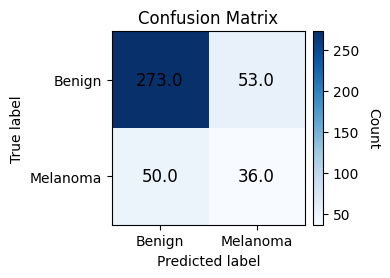

In [21]:
plot_confusion_matrix(cm_matrix, class_names=("Benign", "Melanoma"))
